## Обучение сверточной нейросети распознаванию изображений св. Георгия

In [244]:
import pandas as pd
import requests
from tqdm.notebook import tqdm
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os
import shutil
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.applications import DenseNet169, VGG16, Xception, ResNet152V2
import re
import matplotlib.pyplot as plt
import tensorflow.image

### Обучение модели "с нуля"

Формирование обучающей выборки

In [2]:
georges = pd.read_csv('georges.csv', names = ['Address'])

In [3]:
non_georges = pd.read_csv('non_georges.csv', names = ['Address'])

In [171]:
def plot_history(history):
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(acc))

    plt.plot(epochs, acc, 'bo', label='Точность обучения')
    plt.plot(epochs, val_acc, 'b', label='Точность валидации')
    plt.title('Точность')
    plt.legend()
    plt.grid()

    plt.figure()

    plt.plot(epochs, loss, 'bo', label='Функция потерь обучения')
    plt.plot(epochs, val_loss, 'b', label='Функция потерь валидации')
    plt.title('Функция потерь')
    plt.legend()
    plt.grid()

    plt.show()

In [5]:
size = non_georges.size
with tqdm(total=size) as pbar:
    for counter, address in enumerate(non_georges['Address']):
        r = requests.get(address, allow_redirects=True)
        open('non_georges/' + address.split('/')[-1], 'wb').write(r.content)
        pbar.update(1)


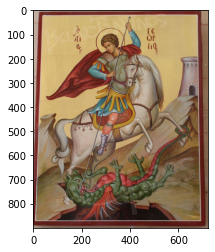

In [286]:
img = image.load_img(os.path.join('georges', '00f07d4b277a6de64488cb1137347db6.jpg'))
plt.imshow(img);

In [6]:
for i, file_name in enumerate(os.listdir('georges')):
    src = os.path.join('georges', file_name)
    if i < len(os.listdir('georges')) * 3 / 4:
        dst = os.path.join('dataset', 'train', 'george', file_name)
    else:
        dst = os.path.join('dataset', 'test', 'george', file_name)
    shutil.copyfile(src, dst)

In [7]:
for i, file_name in enumerate(os.listdir('non_georges')):
    src = os.path.join('non_georges', file_name)
    if i < len(os.listdir('non_georges')) * 3 / 4:
        dst = os.path.join('dataset', 'train', 'non_george', file_name)
    else:
        dst = os.path.join('dataset', 'test', 'non_george', file_name)
    shutil.copyfile(src, dst)

#### Обучение модели без аугментации

In [194]:
train_datagen = ImageDataGenerator(rescale=1./255)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(200, 200),
        batch_size=20,
        class_mode='binary')

test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(200, 200),
        batch_size=20,
        class_mode='binary')

Found 4495 images belonging to 2 classes.
Found 1182 images belonging to 2 classes.


In [195]:
model = models.Sequential()
model.add(layers.Conv2D(8, (3, 3), padding='SAME', activation='relu',
                        input_shape=(200, 200, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(16, (3, 3), padding='SAME', activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(32, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dropout(0.1))
model.add(layers.Dense(1, activation='sigmoid'))

In [196]:
model.compile(loss='binary_crossentropy',
              optimizer=optimizers.Adam(learning_rate=2e-4),
              metrics=['acc'])

In [197]:
history = model.fit(
      train_generator,
      steps_per_epoch=100,
      epochs=30,
      validation_data=test_generator,
      validation_steps=50)

Epoch 1/30
100/100 [==============================] - 20s 200ms/step - loss: 0.6540 - acc: 0.6145 - val_loss: 0.5734 - val_acc: 0.7110
Epoch 2/30
100/100 [==============================] - 20s 200ms/step - loss: 0.5710 - acc: 0.7140 - val_loss: 0.5276 - val_acc: 0.7580
Epoch 3/30
100/100 [==============================] - 20s 200ms/step - loss: 0.5560 - acc: 0.7275 - val_loss: 0.5219 - val_acc: 0.7660
Epoch 4/30
100/100 [==============================] - 20s 200ms/step - loss: 0.5334 - acc: 0.7430 - val_loss: 0.5294 - val_acc: 0.7460
Epoch 5/30
100/100 [==============================] - 20s 200ms/step - loss: 0.5202 - acc: 0.7449 - val_loss: 0.4895 - val_acc: 0.7660
Epoch 6/30
100/100 [==============================] - 20s 200ms/step - loss: 0.5050 - acc: 0.7649 - val_loss: 0.4729 - val_acc: 0.7810
Epoch 7/30
100/100 [==============================] - 20s 200ms/step - loss: 0.4920 - acc: 0.7640 - val_loss: 0.4724 - val_acc: 0.7860
Epoch 8/30
100/100 [==============================] - 2

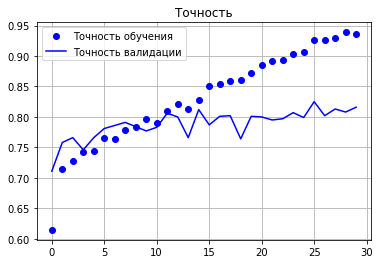

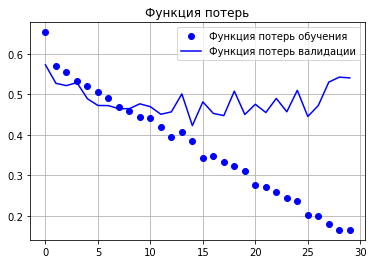

In [198]:
plot_history(history)

#### Обучение модели с применением аугментации

In [249]:
train_dir = os.path.join('dataset', 'train')
test_dir = os.path.join('dataset', 'test')

train_datagen = ImageDataGenerator(rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(200, 200),
        batch_size=20,
        class_mode='binary')

test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(200, 200),
        batch_size=20,
        class_mode='binary')

Found 4495 images belonging to 2 classes.
Found 1182 images belonging to 2 classes.


In [184]:
for data_batch, labels_batch in train_generator:
    print('data batch shape:', data_batch.shape)
    print('labels batch shape:', labels_batch.shape)
    break

data batch shape: (20, 200, 200, 3)
labels batch shape: (20,)


In [185]:
model = models.Sequential()
model.add(layers.Conv2D(8, (3, 3), padding='SAME', activation='relu',
                        input_shape=(200, 200, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(16, (3, 3), padding='SAME', activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(32, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dropout(0.1))
model.add(layers.Dense(1, activation='sigmoid'))

In [186]:
model.summary()

Model: "sequential_30"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_90 (Conv2D)           (None, 200, 200, 8)       224       
_________________________________________________________________
max_pooling2d_82 (MaxPooling (None, 100, 100, 8)       0         
_________________________________________________________________
conv2d_91 (Conv2D)           (None, 100, 100, 16)      1168      
_________________________________________________________________
max_pooling2d_83 (MaxPooling (None, 50, 50, 16)        0         
_________________________________________________________________
conv2d_92 (Conv2D)           (None, 48, 48, 32)        4640      
_________________________________________________________________
max_pooling2d_84 (MaxPooling (None, 24, 24, 32)        0         
_________________________________________________________________
conv2d_93 (Conv2D)           (None, 22, 22, 64)      

In [187]:
model.compile(loss='binary_crossentropy',
              optimizer=optimizers.Adam(learning_rate=2e-4),
              metrics=['acc'])

In [188]:
history = model.fit(
      train_generator,
      steps_per_epoch=100,
      epochs=80,
      validation_data=test_generator,
      validation_steps=50)

Epoch 1/80
100/100 [==============================] - 29s 292ms/step - loss: 0.6738 - acc: 0.5855 - val_loss: 0.9130 - val_acc: 0.4480
Epoch 2/80
100/100 [==============================] - 29s 290ms/step - loss: 0.6529 - acc: 0.6280 - val_loss: 0.6077 - val_acc: 0.6870
Epoch 3/80
100/100 [==============================] - 29s 292ms/step - loss: 0.6345 - acc: 0.6590 - val_loss: 0.6171 - val_acc: 0.6720
Epoch 4/80
100/100 [==============================] - 29s 289ms/step - loss: 0.6174 - acc: 0.6685 - val_loss: 0.5677 - val_acc: 0.7190
Epoch 5/80
100/100 [==============================] - 29s 291ms/step - loss: 0.6129 - acc: 0.6685 - val_loss: 0.5661 - val_acc: 0.7160
Epoch 6/80
100/100 [==============================] - 29s 289ms/step - loss: 0.6149 - acc: 0.6745 - val_loss: 0.5718 - val_acc: 0.7040
Epoch 7/80
100/100 [==============================] - 29s 289ms/step - loss: 0.6002 - acc: 0.6810 - val_loss: 0.5689 - val_acc: 0.7280
Epoch 8/80
100/100 [==============================] - 2

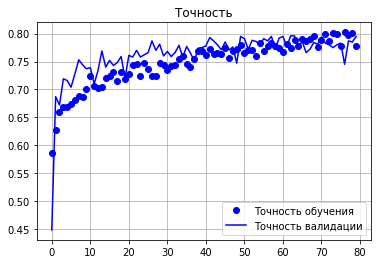

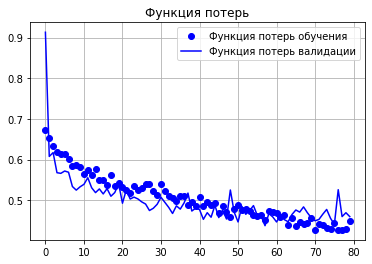

In [189]:
plot_history(history)

Достигнута accuracy ~ 80%.

### Обучение модели с различными предобученными сверточными основами

In [212]:
def build_model(conv_base, freezed_layers = None):
    model = models.Sequential()
    model.add(conv_base)
    model.add(layers.Flatten())
    model.add(layers.Dense(256, activation='relu'))
    model.add(layers.Dense(1, activation='sigmoid'))

    conv_base.trainable = True
    for layer in conv_base.layers:
        if freezed_layers and re.match(freezed_layers, layer.name):
            layer.trainable = True
        else:
            layer.trainable = False

    model.compile(loss='binary_crossentropy',
                  optimizer=optimizers.Adam(learning_rate=1e-4),
                  metrics=['acc'])
    
    history = model.fit(
          train_generator,
          steps_per_epoch=100,
          epochs=40,
          validation_data=test_generator,
          validation_steps=50)
    return history

#### DenseNet169

In [219]:
conv_base = DenseNet169(weights='imagenet',
                  include_top=False,
                  input_shape=(200, 200, 3))

In [220]:
conv_base.summary()

Model: "densenet169"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_12 (InputLayer)           [(None, 200, 200, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d_4 (ZeroPadding2D (None, 206, 206, 3)  0           input_12[0][0]                   
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 100, 100, 64) 9408        zero_padding2d_4[0][0]           
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 100, 100, 64) 256         conv1/conv[0][0]                 
________________________________________________________________________________________

In [221]:
history = build_model(conv_base, r'conv5')

Epoch 1/40
100/100 [==============================] - 30s 237ms/step - loss: 0.4690 - acc: 0.7960 - val_loss: 0.3759 - val_acc: 0.8670
Epoch 2/40
100/100 [==============================] - 20s 205ms/step - loss: 0.2140 - acc: 0.9170 - val_loss: 0.2837 - val_acc: 0.8930
Epoch 3/40
100/100 [==============================] - 20s 204ms/step - loss: 0.1268 - acc: 0.9610 - val_loss: 0.3157 - val_acc: 0.9050
Epoch 4/40
100/100 [==============================] - 21s 205ms/step - loss: 0.1148 - acc: 0.9615 - val_loss: 0.2859 - val_acc: 0.9110
Epoch 5/40
100/100 [==============================] - 21s 205ms/step - loss: 0.0668 - acc: 0.9775 - val_loss: 0.3042 - val_acc: 0.9090
Epoch 6/40
100/100 [==============================] - 20s 204ms/step - loss: 0.0785 - acc: 0.9785 - val_loss: 0.2859 - val_acc: 0.9140
Epoch 7/40
100/100 [==============================] - 21s 205ms/step - loss: 0.0341 - acc: 0.9890 - val_loss: 0.3253 - val_acc: 0.9070
Epoch 8/40
100/100 [==============================] - 2

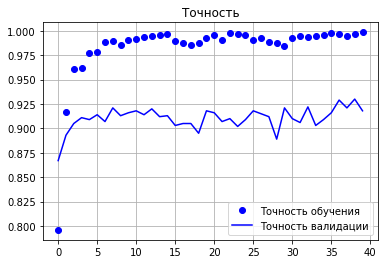

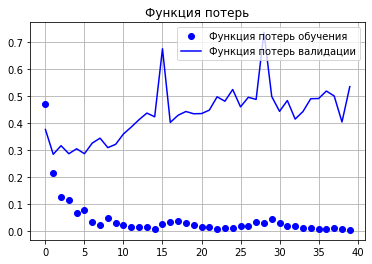

In [222]:
plot_history(history)

#### Xception

In [228]:
conv_base = Xception(include_top=False,
                  input_shape=(200, 200, 3),
                  pooling='avg')

In [229]:
conv_base.summary()

Model: "xception"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_14 (InputLayer)           [(None, 200, 200, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 99, 99, 32)   864         input_14[0][0]                   
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 99, 99, 32)   128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 99, 99, 32)   0           block1_conv1_bn[0][0]            
___________________________________________________________________________________________

In [230]:
history = build_model(conv_base, r'block14|batch_normalization_7|conv2d_112')

Epoch 1/40
100/100 [==============================] - 24s 215ms/step - loss: 0.4797 - acc: 0.7799 - val_loss: 0.3338 - val_acc: 0.8570
Epoch 2/40
100/100 [==============================] - 20s 200ms/step - loss: 0.3111 - acc: 0.8722 - val_loss: 0.2973 - val_acc: 0.8720
Epoch 3/40
100/100 [==============================] - 20s 204ms/step - loss: 0.2228 - acc: 0.9140 - val_loss: 0.2719 - val_acc: 0.8930
Epoch 4/40
100/100 [==============================] - 20s 201ms/step - loss: 0.1790 - acc: 0.9323 - val_loss: 0.2754 - val_acc: 0.8870
Epoch 5/40
100/100 [==============================] - 20s 201ms/step - loss: 0.1465 - acc: 0.9489 - val_loss: 0.2547 - val_acc: 0.9120
Epoch 6/40
100/100 [==============================] - 20s 202ms/step - loss: 0.1186 - acc: 0.9525 - val_loss: 0.2696 - val_acc: 0.9070
Epoch 7/40
100/100 [==============================] - 20s 199ms/step - loss: 0.0844 - acc: 0.9730 - val_loss: 0.3727 - val_acc: 0.8710
Epoch 8/40
100/100 [==============================] - 2

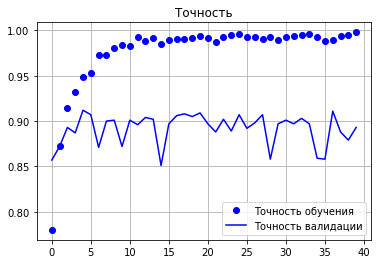

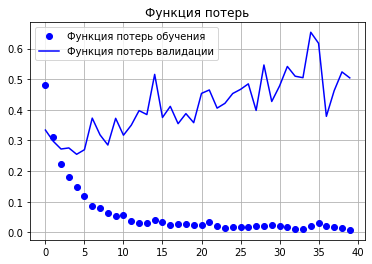

In [231]:
plot_history(history)

#### ResNet152

In [245]:
conv_base = ResNet152V2(include_top=False,
                  input_shape=(200, 200, 3),
                  pooling='avg')

234553344/234545216 [==============================] - 30s 0us/step


In [246]:
conv_base.summary()

Model: "resnet152v2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_17 (InputLayer)           [(None, 200, 200, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 206, 206, 3)  0           input_17[0][0]                   
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 100, 100, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
pool1_pad (ZeroPadding2D)       (None, 102, 102, 64) 0           conv1_conv[0][0]                 
________________________________________________________________________________________

In [247]:
history = build_model(conv_base, r'post_bn|conv5')

Epoch 1/40
100/100 [==============================] - 28s 228ms/step - loss: 0.4246 - acc: 0.8030 - val_loss: 0.3082 - val_acc: 0.8710
Epoch 2/40
100/100 [==============================] - 21s 207ms/step - loss: 0.2002 - acc: 0.9268 - val_loss: 0.2956 - val_acc: 0.9000
Epoch 3/40
100/100 [==============================] - 21s 207ms/step - loss: 0.1558 - acc: 0.9445 - val_loss: 0.2440 - val_acc: 0.9150
Epoch 4/40
100/100 [==============================] - 21s 207ms/step - loss: 0.0790 - acc: 0.9694 - val_loss: 0.2774 - val_acc: 0.9200
Epoch 5/40
100/100 [==============================] - 21s 209ms/step - loss: 0.0675 - acc: 0.9765 - val_loss: 0.3242 - val_acc: 0.8970
Epoch 6/40
100/100 [==============================] - 21s 206ms/step - loss: 0.0748 - acc: 0.9749 - val_loss: 0.3211 - val_acc: 0.9070
Epoch 7/40
100/100 [==============================] - 21s 206ms/step - loss: 0.0500 - acc: 0.9820 - val_loss: 0.4079 - val_acc: 0.9130
Epoch 8/40
100/100 [==============================] - 2

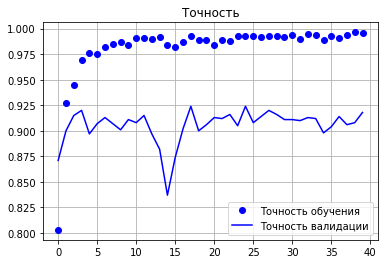

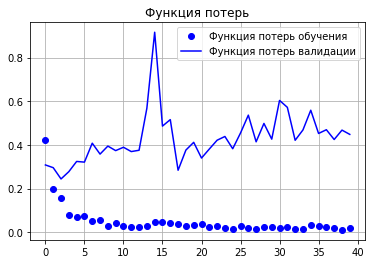

In [248]:
plot_history(history)

#### VGG16

In [199]:
conv_base = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(200, 200, 3))

In [200]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         [(None, 200, 200, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 200, 200, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 200, 200, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 100, 100, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 100, 100, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 100, 100, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 50, 50, 128)       0     

In [214]:
history = build_model(conv_base, r'block4_conv3|block5_conv')

Epoch 1/40
100/100 [==============================] - 21s 206ms/step - loss: 0.5028 - acc: 0.7509 - val_loss: 0.3817 - val_acc: 0.8270
Epoch 2/40
100/100 [==============================] - 20s 202ms/step - loss: 0.3237 - acc: 0.8685 - val_loss: 0.2847 - val_acc: 0.8910
Epoch 3/40
100/100 [==============================] - 20s 201ms/step - loss: 0.2736 - acc: 0.8920 - val_loss: 0.2660 - val_acc: 0.8990
Epoch 4/40
100/100 [==============================] - 20s 200ms/step - loss: 0.2087 - acc: 0.9235 - val_loss: 0.4030 - val_acc: 0.8350
Epoch 5/40
100/100 [==============================] - 20s 205ms/step - loss: 0.1567 - acc: 0.9425 - val_loss: 0.3070 - val_acc: 0.8800
Epoch 6/40
100/100 [==============================] - 20s 201ms/step - loss: 0.1133 - acc: 0.9544 - val_loss: 0.4568 - val_acc: 0.8710
Epoch 7/40
100/100 [==============================] - 20s 201ms/step - loss: 0.1113 - acc: 0.9609 - val_loss: 0.2933 - val_acc: 0.8910
Epoch 8/40
100/100 [==============================] - 2

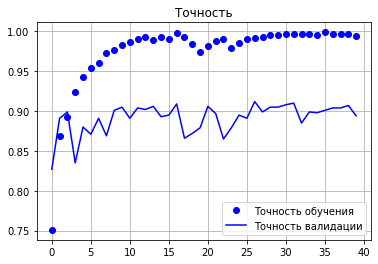

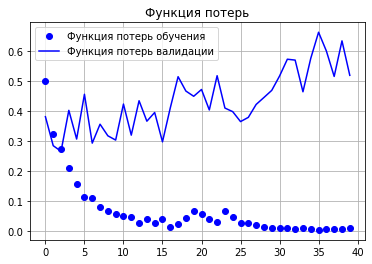

In [215]:
plot_history(history)

Наилучшие результаты дала архитектура DenseNet169. Используем ее для поэтапного обучения.

### Поэтапное обучение с использованием сверточной основы DenseNet169

In [264]:
conv_base = DenseNet169(weights='imagenet',
                  include_top=False,
                  input_shape=(200, 200, 3))

In [265]:
model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid'))

In [266]:
model.summary()

Model: "sequential_42"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet169 (Functional)     (None, 6, 6, 1664)        12642880  
_________________________________________________________________
flatten_41 (Flatten)         (None, 59904)             0         
_________________________________________________________________
dense_82 (Dense)             (None, 256)               15335680  
_________________________________________________________________
dropout_19 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_83 (Dense)             (None, 1)                 257       
Total params: 27,978,817
Trainable params: 27,820,417
Non-trainable params: 158,400
_________________________________________________________________


#### Этап 1. Обучение полносвязного классификатора (20 эпох)

In [267]:
conv_base.trainable = False

In [268]:
model.compile(loss='binary_crossentropy',
              optimizer=optimizers.Adam(learning_rate=1e-4),
              metrics=['acc'])

In [269]:
history = model.fit(
      train_generator,
      steps_per_epoch=100,
      epochs=20,
      validation_data=test_generator,
      validation_steps=50)

Epoch 1/20
100/100 [==============================] - 35s 307ms/step - loss: 0.6916 - acc: 0.7038 - val_loss: 0.5040 - val_acc: 0.7450
Epoch 2/20
100/100 [==============================] - 29s 294ms/step - loss: 0.4782 - acc: 0.7714 - val_loss: 0.3843 - val_acc: 0.8140
Epoch 3/20
100/100 [==============================] - 29s 293ms/step - loss: 0.4238 - acc: 0.8085 - val_loss: 0.3199 - val_acc: 0.8670
Epoch 4/20
100/100 [==============================] - 29s 293ms/step - loss: 0.4281 - acc: 0.8090 - val_loss: 0.3252 - val_acc: 0.8490
Epoch 5/20
100/100 [==============================] - 29s 290ms/step - loss: 0.3936 - acc: 0.8271 - val_loss: 0.3001 - val_acc: 0.8810
Epoch 6/20
100/100 [==============================] - 29s 294ms/step - loss: 0.3818 - acc: 0.8316 - val_loss: 0.3172 - val_acc: 0.8590
Epoch 7/20
100/100 [==============================] - 30s 297ms/step - loss: 0.3757 - acc: 0.8320 - val_loss: 0.2936 - val_acc: 0.8890
Epoch 8/20
100/100 [==============================] - 2

#### Этап 2. Дообучение полносвязного классификатора и верхних слоев основы со скоростью `2е-5` (20 эпох)

In [270]:
conv_base.trainable = True
for layer in conv_base.layers:
    if re.match(r'conv5|bn', layer.name):
        layer.trainable = True
    else:
        layer.trainable = False

In [271]:
model.compile(loss='binary_crossentropy',
              optimizer=optimizers.Adam(learning_rate=2e-5),
              metrics=['acc'])

In [272]:
history2 = model.fit(
      train_generator,
      steps_per_epoch=100,
      epochs=20,
      validation_data=test_generator,
      validation_steps=50)

Epoch 1/20
100/100 [==============================] - 37s 313ms/step - loss: 0.3214 - acc: 0.8610 - val_loss: 0.2609 - val_acc: 0.9000
Epoch 2/20
100/100 [==============================] - 29s 295ms/step - loss: 0.2951 - acc: 0.8745 - val_loss: 0.2768 - val_acc: 0.8920
Epoch 3/20
100/100 [==============================] - 30s 296ms/step - loss: 0.2668 - acc: 0.8897 - val_loss: 0.2572 - val_acc: 0.9090
Epoch 4/20
100/100 [==============================] - 30s 296ms/step - loss: 0.2330 - acc: 0.9008 - val_loss: 0.2491 - val_acc: 0.9030
Epoch 5/20
100/100 [==============================] - 30s 297ms/step - loss: 0.2448 - acc: 0.9065 - val_loss: 0.2578 - val_acc: 0.9080
Epoch 6/20
100/100 [==============================] - 30s 296ms/step - loss: 0.2159 - acc: 0.9143 - val_loss: 0.2713 - val_acc: 0.9050
Epoch 7/20
100/100 [==============================] - 30s 295ms/step - loss: 0.1951 - acc: 0.9210 - val_loss: 0.2564 - val_acc: 0.9190
Epoch 8/20
100/100 [==============================] - 3

#### Этап 3. Дообучение полносвязного классификатора и верхних слоев со скоростью `1е-5` (30 эпох)

In [273]:
model.compile(loss='binary_crossentropy',
              optimizer=optimizers.Adam(learning_rate=1e-5),
              metrics=['acc'])
history3 = model.fit(
              train_generator,
              steps_per_epoch=100,
              epochs=30,
              validation_data=test_generator,
              validation_steps=50)

Epoch 1/30
100/100 [==============================] - 38s 311ms/step - loss: 0.1146 - acc: 0.9585 - val_loss: 0.2817 - val_acc: 0.9230
Epoch 2/30
100/100 [==============================] - 29s 293ms/step - loss: 0.0931 - acc: 0.9664 - val_loss: 0.3002 - val_acc: 0.9240
Epoch 3/30
100/100 [==============================] - 29s 293ms/step - loss: 0.0922 - acc: 0.9649 - val_loss: 0.2790 - val_acc: 0.9290
Epoch 4/30
100/100 [==============================] - 29s 295ms/step - loss: 0.1156 - acc: 0.9574 - val_loss: 0.2761 - val_acc: 0.9290
Epoch 5/30
100/100 [==============================] - 29s 294ms/step - loss: 0.1235 - acc: 0.9569 - val_loss: 0.2577 - val_acc: 0.9250
Epoch 6/30
100/100 [==============================] - 30s 296ms/step - loss: 0.0917 - acc: 0.9684 - val_loss: 0.2926 - val_acc: 0.9250
Epoch 7/30
100/100 [==============================] - 30s 296ms/step - loss: 0.0895 - acc: 0.9670 - val_loss: 0.2942 - val_acc: 0.9200
Epoch 8/30
100/100 [==============================] - 3

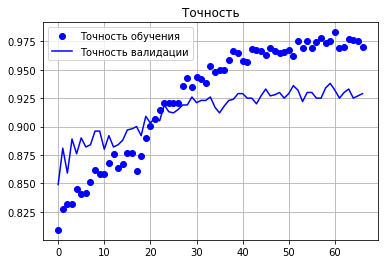

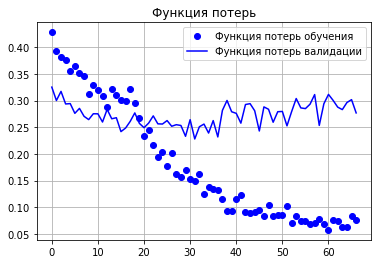

In [282]:
acc = history.history['acc'][3:] + history2.history['acc'] + history3.history['acc']
val_acc = history.history['val_acc'][3:] + history2.history['val_acc'] + history3.history['val_acc']
loss = history.history['loss'][3:] + history2.history['loss'] + history3.history['loss']
val_loss = history.history['val_loss'][3:] + history2.history['val_loss'] + history3.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Точность обучения')
plt.plot(epochs, val_acc, 'b', label='Точность валидации')
plt.title('Точность')
plt.legend()
plt.grid()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Функция потерь обучения')
plt.plot(epochs, val_loss, 'b', label='Функция потерь валидации')
plt.title('Функция потерь')
plt.legend()
plt.grid()

plt.show()

В итоге достигнута accuracy ~ 93%.

In [283]:
model.save("george_classifier.h5")

In [325]:
img = image.load_img(os.path.join('non_georges', '3e3c0e893015f3258b7c32b2c3211061.jpg'))
x = image.img_to_array(img)
x = tensorflow.image.resize(x, [200,200])
x = x.numpy().reshape((1,) + x.shape)

model.predict(x, verbose=1)

1/1 [==============================] - 0s 25ms/step


array([[1.]], dtype=float32)

In [327]:
x.shape

(1, 200, 200, 3)

[[0.99714345]]
1.0
[[0.0055617]]
0.0
[[0.9999305]]
1.0
[[0.9999999]]
1.0
[[0.01607768]]
0.0
[[0.9999975]]
1.0
[[0.9999696]]
1.0
[[0.9996326]]
1.0
[[0.00666259]]
0.0
[[0.5375046]]
1.0
[[0.90339655]]
1.0
[[0.0166911]]
0.0
[[0.04684813]]
1.0
[[3.2163055e-06]]
0.0
[[4.981365e-06]]
0.0
[[0.99995875]]
1.0
[[0.94163835]]
1.0
[[0.00703211]]
1.0
[[0.00471765]]
0.0
[[0.9999596]]
1.0


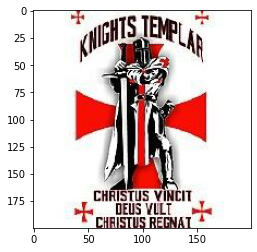

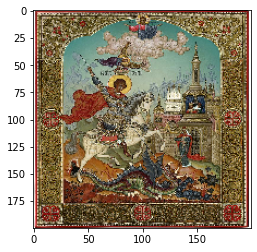

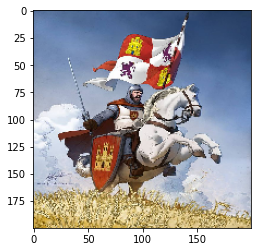

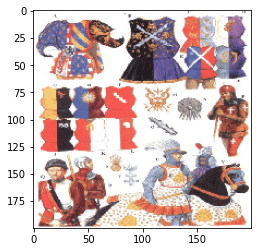

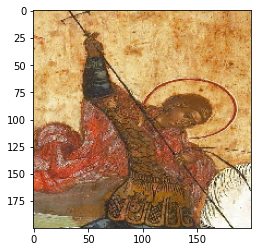

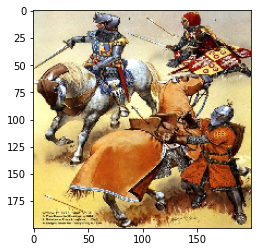

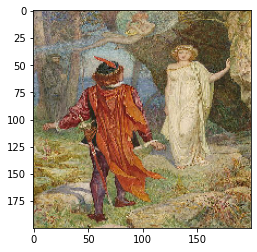

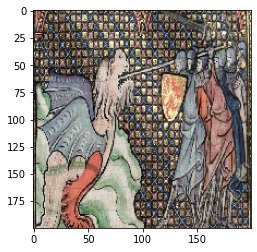

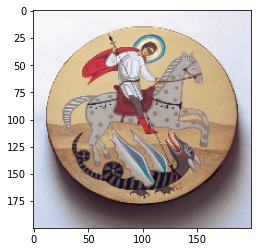

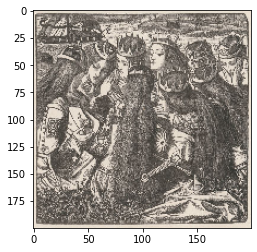

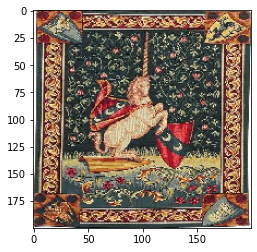

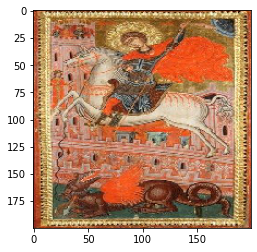

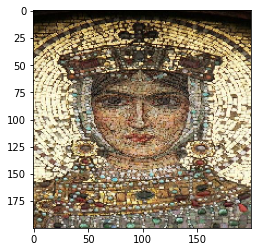

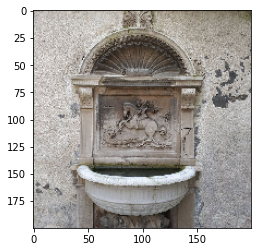

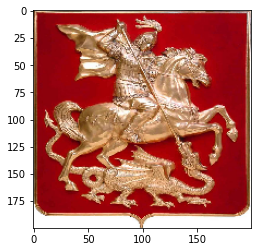

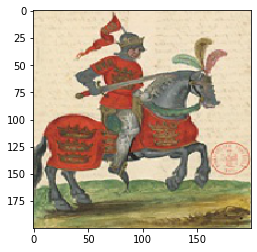

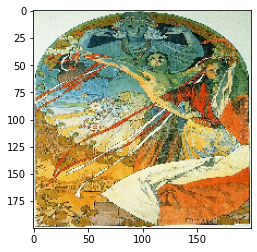

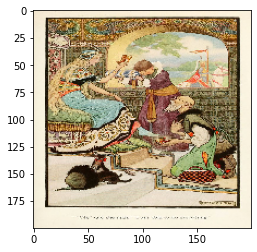

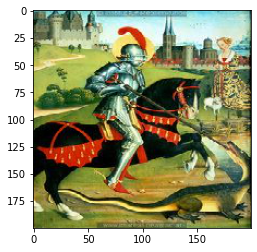

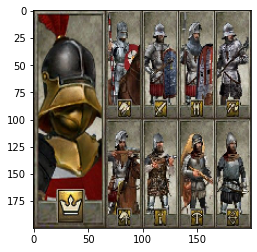

In [348]:
xs = []
pr2 = None
for data_batch, labels_batch in test_generator:
    for j, image in enumerate(data_batch):
        plt.figure(j)
        plt.imshow(image);
        pr = model.predict(image.reshape((1,) + image.shape))
        print(pr)
        lb = labels_batch[j]
        print(lb)
        xs.append(pr)
    pr2 = model.predict(data_batch)
    break
